In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Notebook for analyzing electron-impact ionization of $H_2$ in rswarp

## Import needed modules

In [2]:
%matplotlib inline

import sys
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_e
from rswarp.utilities import file_utils

## Load output data generated by ionization.py

In [7]:
path = 'diags10.000keV/hdf5/'
full =  file_utils.loadparticlefiles(path)

#print full[1000]['H2+'][0,:]
## Output is array of size 7: x, ux, y, uy, z, uz, 1.0 (gamma?)
#print full[1000]['H2+'][:,6] - 1

#step_min = min(full.keys())
#step_max = max(full.keys())

## Assume uniform spacing
#step_interval = step_max  / len(full.keys())

## Grab simulation attributes we'll need 
#ff = h5.File(path + 'data00001000.h5', 'r')
#beam_sw = np.average(ff['data/1000/particles/e-/weighting'])  # Macroparticle weight of beam
#ion_sw = np.average(ff['data/1000/particles/H2+/weighting'])  # Macroparticle weight of ions
#timestep = ff['data/1000'].attrs['dt']
#ff.close()

## Plot angular distribution of emitted electrons

Uses output data generated by defining writeAngleDataDir and setting writeAnglePeriod=1

Total number of ionization events:  1439


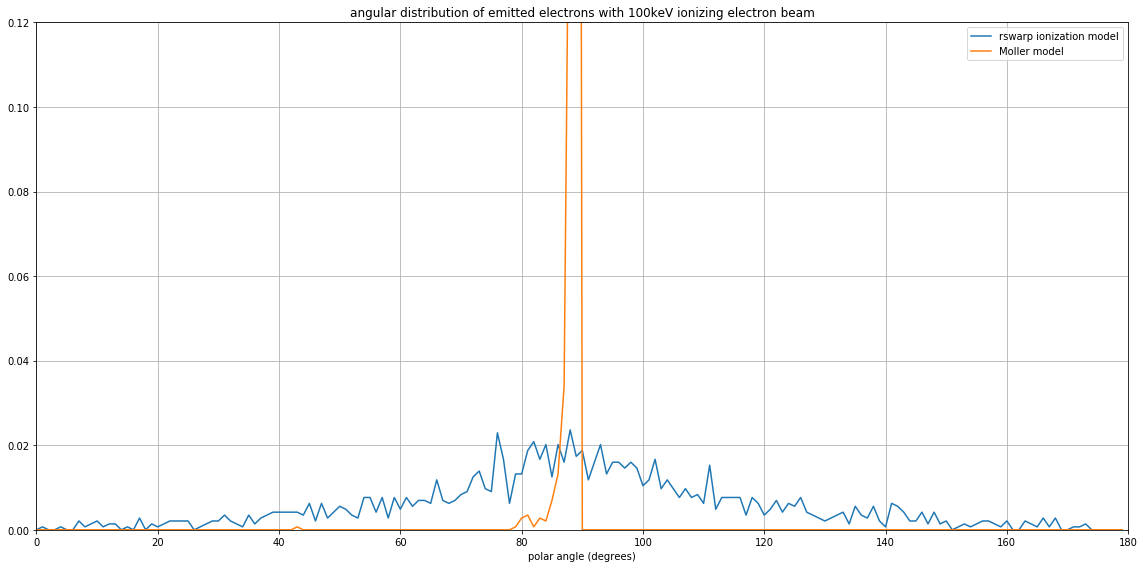

In [20]:
plt.figure(figsize=(16, 8))
plt.title('angular distribution of emitted electrons with 100keV ionizing electron beam')
plt.xlabel('polar angle (degrees)')
plt.xlim(0.0, 180.0)
plt.ylim(0.0, 0.12)
plt.grid(True)

nstep = sorted(full.keys())[-1]
#print nstep; sys.exit(0)
nstep = 10000
f = h5py.File('./diags100.000keV/angledata.h5', 'r')

ang_bins = np.zeros((2, 180))

for i in range(nstep):
    tmp = f['data/' + str(i+1) + '/e-/emitted e-/incidentvelocities'][:]
#    tmp = f['data/' + str(i+1) + '/e-/H2+/incidentvelocities'][:]
    if tmp.size > 0:
        n = tmp.size / 3
        u0 = np.reshape(tmp, (n, 3))
        u1 = np.reshape(f['data/' + str(i+1) + '/e-/emitted e-/emittedvelocities'][:], (n, 3))
        for j in range(n):
            sqr = lambda x: x * x
            costheta = (u0[j,0] * u1[j,0] + u0[j,1] * u1[j,1] + u0[j,2] * u1[j,2])
            costheta /= math.sqrt(sqr(u0[j,0]) + sqr(u0[j,1]) + sqr(u0[j,2]))
            costheta /= math.sqrt(sqr(u1[j,0]) + sqr(u1[j,1]) + sqr(u1[j,2]))
            thetadeg = 180. / math.pi * math.acos(costheta)
            if math.isnan(thetadeg):
                print 'Simulation data', costheta, u0[j,:], u1[j,:]
            else:
                ang_bins[0, math.trunc(thetadeg)] += 1
            c2 = sqr(c)
            eps = lambda u0, u1, u2: m_e * c2 * (math.sqrt(1.0 + (sqr(u0) + sqr(u1) + sqr(u2)) / c2) - 1.0)
            eps0 = eps(u0[j,0], u0[j,1], u0[j,2])
            eps1 = eps(u1[j,0], u1[j,1], u1[j,2])
            costheta = eps1 * (eps0 + 2.0 * m_e * c2)
            costheta /= eps0 * (eps1 + 2.0 * m_e * c2)
            costheta = math.sqrt(costheta)
            thetadeg = 180. / math.pi * math.acos(costheta)
            if math.isnan(thetadeg):
                print 'Moller model, ', costheta, u0[j,:], u1[j,:]
            else:
                ang_bins[1, math.trunc(thetadeg)] += 1
print 'Total number of ionization events: ', math.trunc(ang_bins[0, :].sum())
ang_bins[0, :] /= ang_bins[0, :].sum() # Unity-integral normalization
ang_bins[1, :] /= ang_bins[1, :].sum()
plt.plot(ang_bins[0, :], label='rswarp ionization model')
plt.plot(ang_bins[1, :], label='Moller model')
#plt.legend(prop = {'size': 10}, loc = 'upper right')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('ang_bins.png')
plt.show()